In [1]:
%load_ext autoreload
%autoreload 2

# Dimensionality reduction
SVD and NMF demo for Caiman 2023 Satellite Workshop.

First imports and setup.

In [ ]:
!pip install scikit-learn matplotlib numpy imageio

In [2]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import HTML
from base64 import b64encode
from numpy.random import RandomState # random seed
%env HV_DOC_HTML=true

rng = RandomState(0) # set seed

env: HV_DOC_HTML=true


### Singular value decomposition (SVD)

In [3]:
n_row, n_col = 6, 4 # how many components to plot
n_components = n_row * n_col
image_shape = (64, 64)

Get Olivetti Faces dataset. Contains 400 faces that have been cropped to 64x64 (4096 raveled) images.

In [4]:
faces, _ = fetch_olivetti_faces(return_X_y=True,
                                shuffle=True,
                                random_state=rng)
n_samples, n_features = faces.shape
print(n_samples,n_features)
print(np.sqrt(n_features))

400 4096
64.0


Plot a sample:

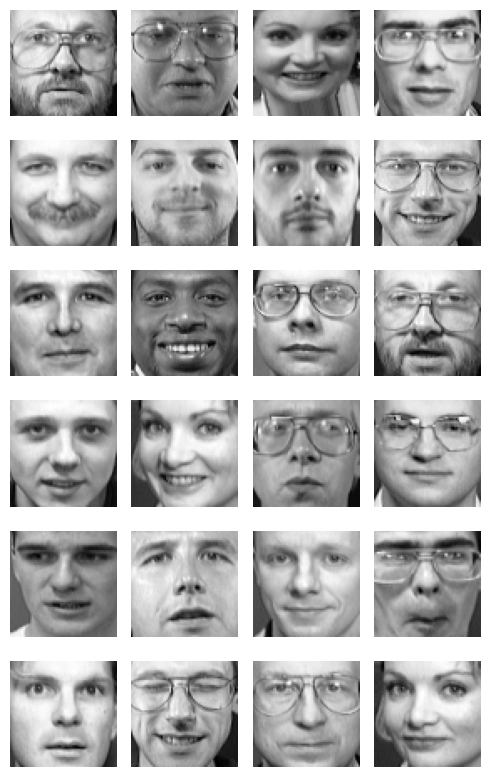

In [5]:
# plot a sample
plt.figure(figsize=(5, 8))
for face_id, face in enumerate(faces[:n_components]):
    plt.subplot(n_row,n_col,face_id+1)
    plt.imshow(face.reshape(image_shape), cmap='gray')
    plt.axis('off')
plt.tight_layout()

Mean center the data and show mean face:

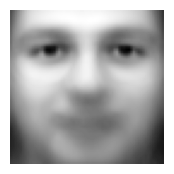

In [6]:
mn_face = faces.mean(axis=0)
faces_centered = faces - mn_face

plt.figure(figsize=(3,2))
plt.imshow(mn_face.reshape(image_shape), cmap='gray');
plt.axis('off');

Plot mean-centered faces

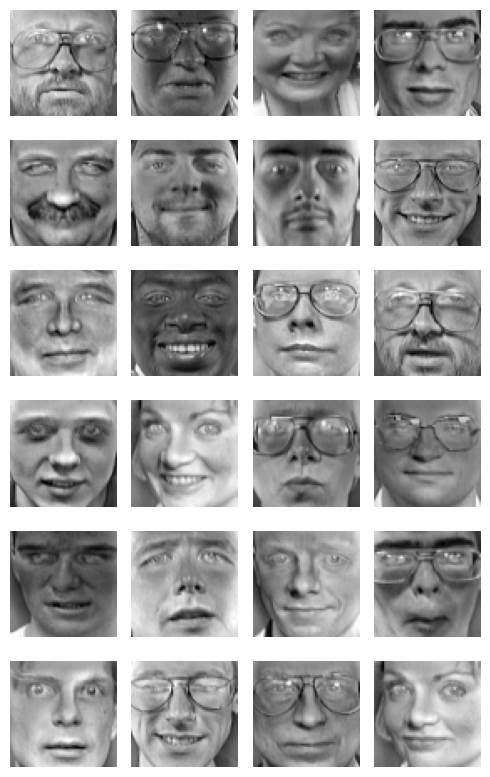

In [7]:
plt.figure(figsize=(5,8))
for face_id, face in enumerate(faces_centered[:n_components]):
  plt.subplot(n_row, n_col, face_id+1)
  plt.imshow(face.reshape(image_shape), cmap='gray')
  plt.axis('off')
plt.tight_layout()

Do SVD. As we saw, this decomposes matrix A into feature fectors U, singular values S, and coordinate/coefficient matrix V (or V transposed VT):

In [8]:
%%time
U, S, VT = np.linalg.svd(faces_centered.T, full_matrices=False) # does on truncated
perc_var_exp = S/np.sum(S)

CPU times: total: 500 ms
Wall time: 69.8 ms


Each singular value contains the amount of variance explained let's see how much of the total for the first few.

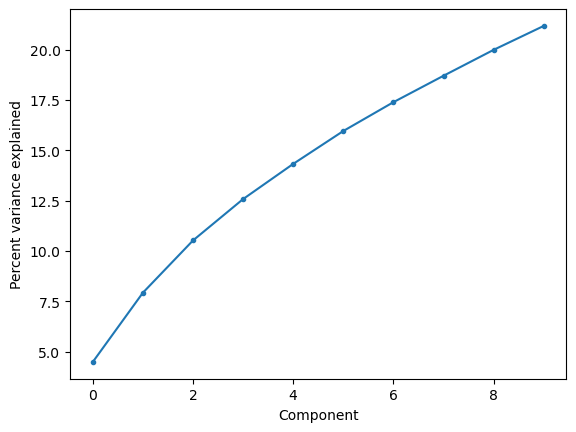

In [9]:
perc_var_exp = S/np.sum(S)
plt.plot(100*np.cumsum(perc_var_exp[:10]), marker='.');
plt.xlabel('Component')
plt.ylabel('Percent variance explained');

Plot the average face and the first few eigenfaces (first few columns of U).

Title shows column number and percent variance explained.

In [10]:
eigen_rows = 5
eigen_cols = 4
n_eigenplots = eigen_rows*eigen_cols

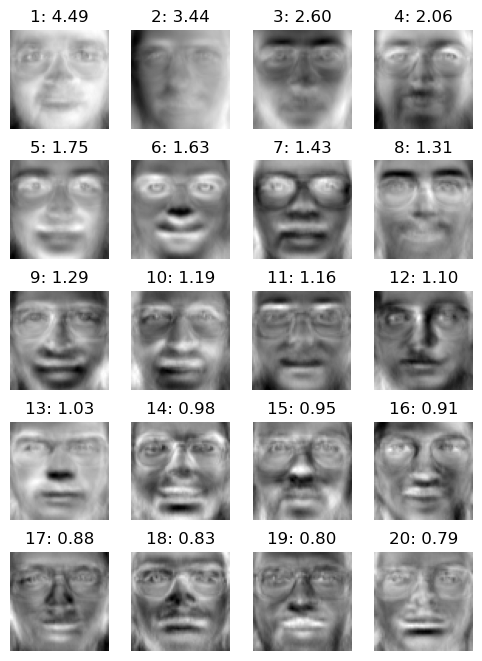

In [11]:
plt.figure(figsize=(5,8))
for eigen_id, eigenface in enumerate(U[:,:n_eigenplots].T):
   var_exp = perc_var_exp[eigen_id]
   plt.subplot(n_row,n_col,eigen_id+1)
   plt.title(f"{eigen_id+1}: {100*var_exp:0.2f}")
   plt.imshow(eigenface.reshape(image_shape), cmap='gray') # seismic
   plt.axis('off')
plt.tight_layout()

Show color-coded by positive (red)/negative(blue):

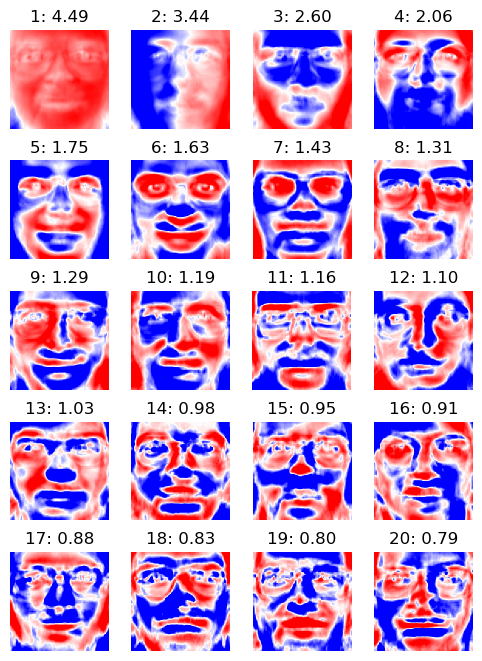

In [12]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vcenter=0.)
plt.figure(figsize=(5,8))
for eigen_id, eigenface in enumerate(U[:,:n_eigenplots].T):
   var_exp = perc_var_exp[eigen_id]
   plt.subplot(n_row,n_col,eigen_id+1)
   plt.title(f"{eigen_id+1}: {100*var_exp:0.2f}")
   plt.imshow(eigenface.reshape(image_shape), cmap='bwr', norm=divnorm) # coolwarm/bwr
   plt.axis('off')
plt.tight_layout()

Plot an arbitrary eigenface (there are 400)

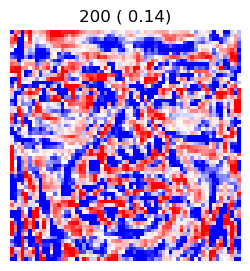

In [13]:
ghost_ind = 200
var_exp = perc_var_exp[ghost_ind]
ghost_face = U[:,ghost_ind].reshape(image_shape)

f, ax = plt.subplots(figsize=(3,3))
ax.imshow(ghost_face, cmap='bwr', norm=divnorm)
ax.axis('off')
ax.set_title(f"{ghost_ind} ({100*var_exp: 0.2f})", fontsize=12);

## Project face to lower-rank eigenface

Note **there is bias** in dataset -- this will influence reconstruction quality at low rank!

- 20 no glasses or facial hair, with surprised look (male)
- 2 woman smiling
- 4 male with facial hair
- 9 black male

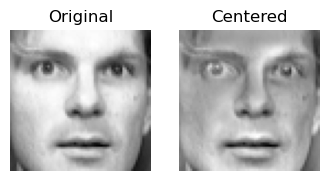

In [14]:
face_ind = 20
## Now show eigenface reconstruction of image that was omitted from test set
test_face = faces[face_ind, :] # First face of person 37
test_centered = faces_centered[face_ind, :]

f, (ax1, ax2) = plt.subplots(1,2, figsize=(4,2))
ax1.imshow(test_face.reshape(image_shape), cmap='gray')
ax1.set_title('Original')
ax1.axis('off');

ax2.imshow(test_centered.reshape(image_shape), cmap='gray')
ax2.set_title('Centered')
ax2.axis('off');

Reconstruct to different rank-p approximations. To project an image x to basis in U just do:

$$
\hat{x} = UU^Tx
$$

You can choose how many columns of U to include for k in the rank-k approximation.

In [15]:
%%time
k_approx = [1, 2, 5, 10, 20, 25, 30, 35, 40, 50, 100, 200, 300, 400]
reconstructed_faces = []
for k in k_approx:
    # reconstructed face U U^T Face
    xhat_p = mn_face + U[:,:k] @ U[:,:k].T @ test_centered
    reconstructed_faces.append(xhat_p)

CPU times: total: 7.27 s
Wall time: 919 ms


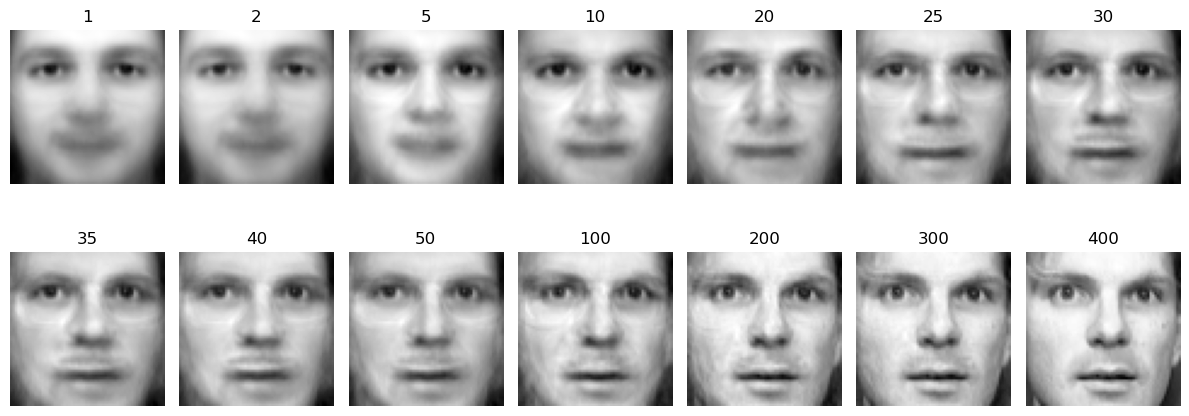

In [16]:
fig, axes = plt.subplots(2,7, figsize=(12,5))
axes = np.ravel(axes)
for img_ind in range(len(reconstructed_faces)):
    axes[img_ind].imshow(reconstructed_faces[img_ind].reshape(image_shape), cmap='gray')
    axes[img_ind].set_title(f"{k_approx[img_ind]}", fontsize=12)
    axes[img_ind].axis('off')
fig.tight_layout()

Now let's try reconstructing an arbitrary image using the feature vectors built up from the face data set.

C:\Users\Eric\AppData\Local\Temp\ipykernel_14928\2247291294.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  random_img = imageio.imread(image_url)


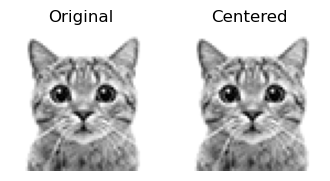

In [17]:
image_url = r'https://raw.githubusercontent.com/flatironinstitute/caiman_central/main/workshops/sfn_2023/dim_reduct/cat.png'

random_img = imageio.imread(image_url)
random_img_col = random_img.reshape(n_features)
random_centered = random_img - mn_face.reshape(image_shape)
random_centered_col = random_centered.reshape(n_features)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(4,2))

ax1.imshow(random_img.reshape(image_shape), cmap='gray')
ax1.set_title('Original')
ax1.axis('off');

ax2.imshow(random_centered.reshape(image_shape), cmap='gray')
ax2.set_title('Centered')
ax2.axis('off');

In [19]:
%%time
k_approx = [1, 2, 5, 10, 20, 25, 30, 35, 40, 50, 100, 200, 300, 400]
reconstructed_rand = []
for k in k_approx:
    # reconstructed face U U^T Face
    xhat_k = mn_face + U[:,:k] @ U[:,:k].T @ random_centered_col
    reconstructed_rand.append(xhat_k)

CPU times: total: 6.89 s
Wall time: 877 ms


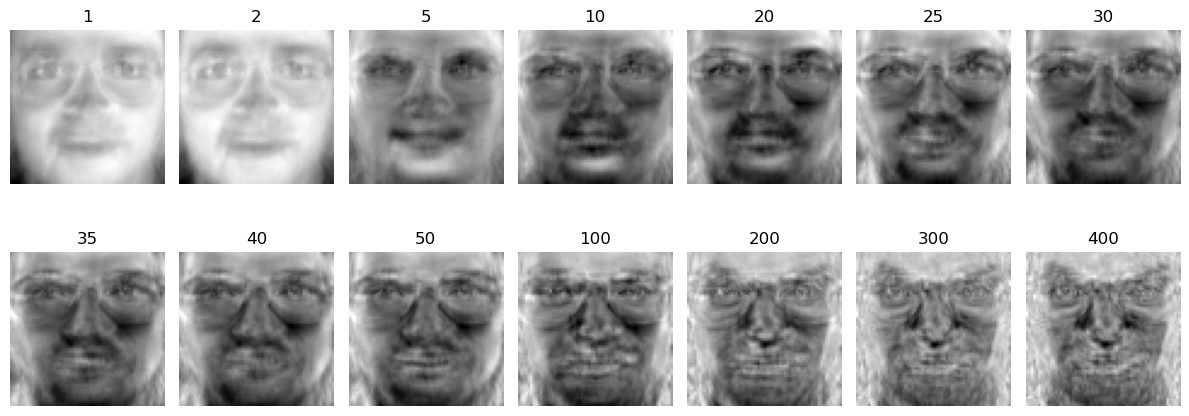

In [20]:
fig, axes = plt.subplots(2,7, figsize=(12,5))
axes = np.ravel(axes)
for img_ind in range(len(reconstructed_rand)):
    axes[img_ind].imshow(reconstructed_rand[img_ind].reshape(image_shape), cmap='gray')
    axes[img_ind].set_title(f"{k_approx[img_ind]}", fontsize=12)
    axes[img_ind].axis('off')
fig.tight_layout()

Why is this so much worse? What is the maximum possible rank of A? How many features are there?

# Nonnegative matrix factorization (NMF)
Goal:

- Find two non-negative matrices (W, H) whose product approximates the nonnegative matrix A.
- The objective function is minimized with an alternating minimization of W and H.

We'll be using [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html), which uses following objective function (and uses the term X for the original matrix for some reason):

$$
\begin{align}
\begin{aligned}
L(W, H) &= 0.5 * ||X - WH||_{loss}^2\\&
+ alpha\_W * l1\_ratio * n\_features * ||vec(W)||_1\\&
+ alpha\_H * l1\_ratio * n\_samples * ||vec(H)||_1\\&
+ 0.5 * alpha\_W * (1 - l1\_ratio) * n\_features * ||W||_{Fro}^2\\&
+ 0.5 * alpha\_H * (1 - l1\_ratio) * n\_samples * ||H||_{Fro}^2
\end{aligned}
\end{align}
$$

Let's ignore the H terms for now, and reduce it to the following by setting $\alpha_H$ to 0:

$$
\begin{align}
\begin{aligned}
L(W, H) &= 0.5 * ||X - WH||_{loss}^2\\&
+ alpha\_W * l1\_ratio * n\_features * ||vec(W)||_1\\&
+ 0.5 * alpha\_W * (1 - l1\_ratio) * n\_features * ||W||_{Fro}^2\\&
\end{aligned}
\end{align}
$$


- The first term is the distance between X and the approximation, which obviously we want to minimize (here we are assuming Frobenius norm, which is the default in scikit-learn's `NMF()`, but you can use other loss functions).
- We can regularize using the L1 norm or L2 (Frobenius) norm. We can regularize the new basis matrix W or the mixing coefficient vectors in H. We will focus on W. Most relevant for us, L1 regularization tends to generate sparse parameter sets,  while L2 regularization tends to make them small but not zero/sparse. For instance, see some great answers [here](https://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models), but also many other great discussion across the interwebs.
- In the model, the *L1_ratio* determines the balance of L1 and L2 used (if the L1 ratio is 1, then only L1 is used, if it is 0, then only L2 is used).

So if we want a sparse face representation, we should set alpha_W very high (say, to 1) and we want to emphasise L1 regularization (naively, we would set *L1_ratio* to 1).

Since we don't really care about H sparseness we should be able to set alpha_H to 0 (also, I find in practice that the `NMF` algorithm behavior is extremelly sensitive to `alpha_H` it is just not very well behaved).

### On sparseness
Rather than just subjectively judge sparseness, let's quantify it.

This is *basically* a measure of how many pixels are being used in a given basis vector, with the wrinkle that if they are all the same value (e.g., all 0.5) then that counts as sparse too -- this is important as this happens quite often, especially if you start tweaking H. So it isn't just a measure of how many zeros are in a vector.

Good review paper on this topic : [Comparing Measures of Sparsity](https://ieeexplore.ieee.org/document/5238742):

> There are many measures of sparsity. Intuitively, a sparse representation is one in which a small number of coefficients contain a large proportion of the energy.

We'll use one useful measure from Hoyer (2004) to compare sparseness of the PCA basis set with that obtained using NMF.

In [21]:
def sparseness_hoyer(x):
    """
    The sparseness of array x is a real number in [0, 1], where sparser array
    has value closer to 1. Sparseness is 1 iff the vector contains a single
    nonzero component and is equal to 0 iff all components of the vector are
    the same

    modified from Hoyer 2004: [sqrt(n)-L1/L2]/[sqrt(n)-1]

    adapted from nimfa package: https://nimfa.biolab.si/
    """
    from math import sqrt # faster than numpy sqrt
    eps = np.finfo(x.dtype).eps if 'int' not in str(x.dtype) else 1e-9

    n = x.size

    # measure is meant for nmf: things get weird for negative values
    if np.min(x) < 0:
        x -= np.min(x)

    # patch for array of zeros
    if np.allclose(x, np.zeros(x.shape), atol=1e-6):
        return 0.0

    L1 = abs(x).sum()
    L2 = sqrt(np.multiply(x, x).sum())
    sparseness_num = sqrt(n) - (L1 + eps) / (L2 + eps)
    sparseness_den = sqrt(n) - 1

    return sparseness_num / sparseness_den

def sparseness(array, axis=0):
    """
    Get sparseness of each column of array (or row)
    Also returns mean sparseness

    only works for up to 2d
    """
    dims = array.ndim
    if dims > 2:
        raise ValueError("sparseness accepts 1d or 2d arrays")

    elif dims == 1:
            sparsity = sparseness_hoyer(array)
    elif dims == 2:
        if axis == 0:
            num_cols = array.shape[1]
            sparsity = []
            for col in np.arange(num_cols):
                col_dat = array[:,col]
                col_sparseness = sparseness_hoyer(col_dat)
                sparsity.append(col_sparseness)
        elif axis == 1:
            num_rows = array.shape[0]
            sparsity = []
            for row in np.arange(num_rows):
                row_dat = array[row,:]
                row_sparseness = sparseness_hoyer(row_dat)
                sparsity.append(row_sparseness)

        sparsity = np.array(sparsity)
    mn_sparsity = np.mean(sparsity)

    return sparsity, mn_sparsity

print('done')

done


### On multiplicative update vs coordinate descent
As you will see, there are two algorithms you can choose in scikit-learn to solve the NMF optimization problem: coordinate descent, or multiplicative update.  Deriving multiplicative update rule is [here](https://stats.stackexchange.com/a/352921/17624).

In practice, they give pretty different results. I'm going to go with the method developed in Lee and Seung (1999) below, multiplicative update. Caiman uses block coordinate descent. They all use some version of *biconvex optimization* in which one variable (W) is held fixed, the solver minimizes the other (H), and then vice-versa..

## First run SVD and get sparseness
Run this all at once

In [22]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

faces, _ = fetch_olivetti_faces(return_X_y=True)
mn_face = faces.mean(axis=0)
faces_centered = faces - mn_face

U, S, VT = np.linalg.svd(faces_centered.T, full_matrices=False)
perc_var_exp = S/np.sum(S)

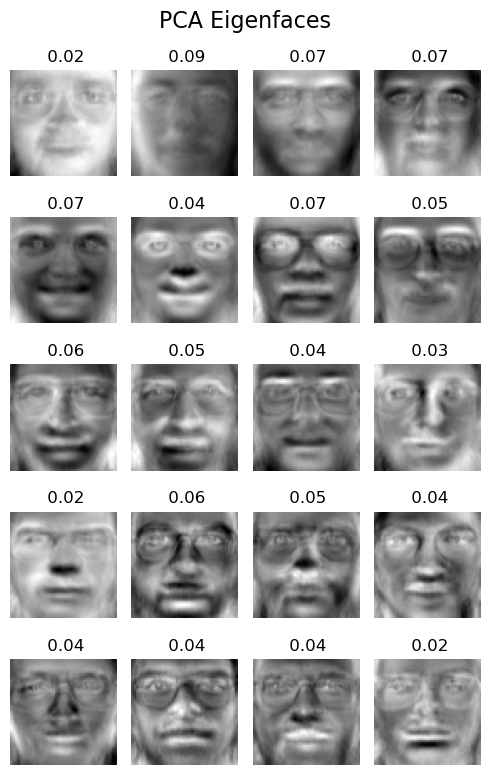

In [25]:
n_row, n_col = 5, 4

plt.figure(figsize=(5,8))
for eigen_id, eigenface in enumerate(U[:,:n_row*n_col].T):
   var_exp = perc_var_exp[eigen_id]
   plt.subplot(n_row,n_col,eigen_id+1)
   plt.title(f"{pca_sparseness[eigen_id]: 0.2f}")
   plt.imshow(eigenface.reshape(image_shape), cmap='gray') # seismic
   plt.axis('off')
plt.suptitle('PCA Eigenfaces', fontsize=16, y=0.98)
plt.tight_layout()

## NMF
There is some repetition of code here, on purpose, so you can run this by itself if you want to skip the PCA step.

In [26]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

faces, _ = fetch_olivetti_faces(return_X_y=True)

Here the parameters are as discussed above in the optimization problem setup. k is the number of basis vectors you want to find in U (and rows of H).

In [27]:
k = 200
alph_W = 0.9  # cd: .9, mu: .9
L1_ratio = 0.9 # cd: 0, L1_ratio: 0.9

In [28]:
%%time
estimator = NMF(k,
                init='nndsvdar', # nndsvd
                solver='mu', #default is 'cd', use 'mu' if you want parts
                max_iter=50,
                alpha_W=alph_W,
                alpha_H=0, # leave as 0 otherwise typically end up with all zeros
                l1_ratio=L1_ratio,
                shuffle=True)

H = estimator.fit_transform(faces)
W = estimator.components_

CPU times: total: 4.72 s
Wall time: 590 ms


C:\Users\Eric\miniconda3\envs\ds\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


Plot the basis faces (features) with their sparseness.

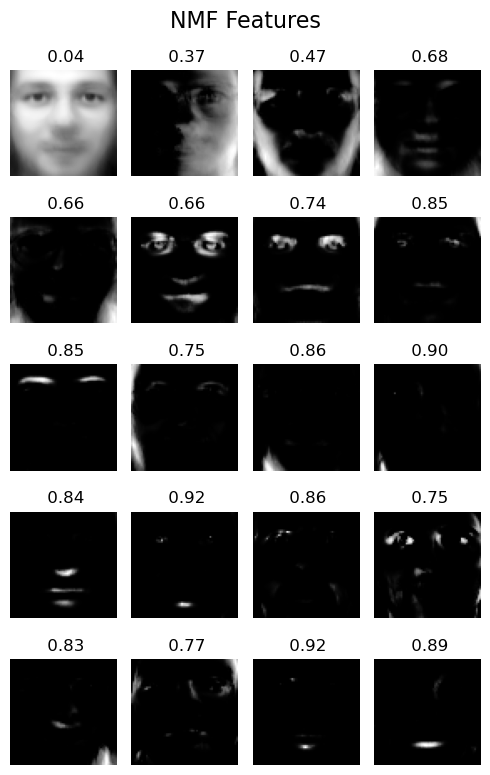

In [29]:
image_shape = (64, 64)
n_samples, n_features = faces.shape
plt.figure(figsize=(5,8))
for face_id, face in enumerate(W[:n_row*n_col]):
    plt.subplot(n_row, n_col, face_id+1)
    face_sparseness = sparseness_hoyer(face)
    plt.imshow(face.reshape(image_shape), cmap='gray')
    plt.title(f"{face_sparseness: 0.2f}")
    plt.axis('off')
plt.suptitle('NMF Features', fontsize=16, y=0.98)
plt.tight_layout()

In [30]:
w_sparseness, w_sparseness_mn = sparseness(W, axis=1);
print(f"Sparseness nmf: {w_sparseness_mn: 0.2f}, PCA: {pca_sparseness_mn: 0.2f}")

Sparseness nmf:  0.92, PCA:  0.03


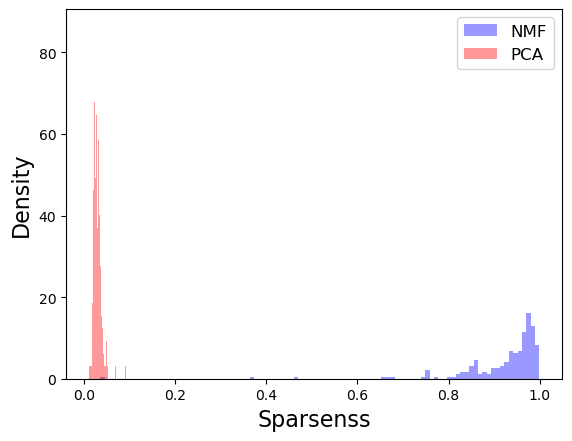

In [31]:
# figure of sparseness of pca vs W
plt.figure()
plt.hist(w_sparseness, color='blue', bins=100, density=True, alpha=0.4, label='NMF');
plt.hist(pca_sparseness, color='red', bins=100, alpha=0.4, density=True, label='PCA');
plt.legend(fontsize=12)
plt.xlabel('Sparsenss', fontsize=16)
plt.ylabel('Density', fontsize=16);

Weirdly, initial components are typically lower sparsity. Why?

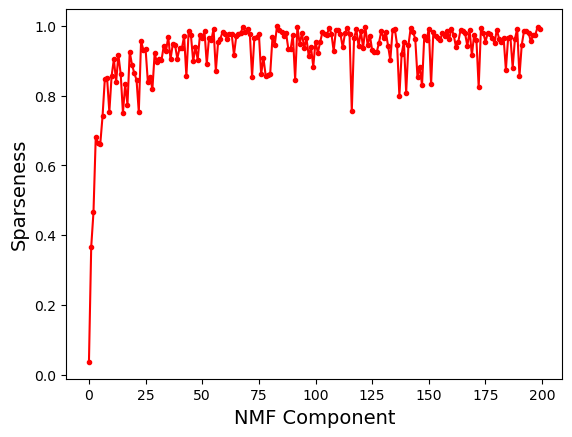

In [32]:
plt.plot(w_sparseness,
        marker='.',
        markersize=6,
        color='r')
plt.xlabel('NMF Component', fontsize=14)
plt.ylabel('Sparseness', fontsize=14);

## NMF with simulated neural data
This is adapted partly from a blog post/Matlab code from Bill Connelly:
http://www.billconnelly.net/?p=534

I wrote it to be readable, not efficient or realistic, so I would not use this for doing actual science or simulations!

First create five component templates.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)

num_frames = 1000
image_size = 200
frame_shape = np.array([image_size, image_size])
component_centers = np.array([[40, 40],
                              [110, 90],
                              [180, 55],
                              [60, 135],
                              [140, 140]]);
component_sigmas = np.array([15, 26.5, 35, 13, 26])
num_components = component_centers.shape[0]

# create component images
x, y = np.meshgrid(np.arange(0, image_size),
                   np.arange(0, image_size))
pos = np.dstack((x, y))
component_images = []
for component_num in np.arange(num_components):
    component_mean = component_centers[component_num]
    component_sigma = component_sigmas[component_num]
    gauss_rep = multivariate_normal(component_mean, component_sigma)
    gauss_img = gauss_rep.pdf(pos)
    component_images.append(gauss_img)
component_images = np.array(component_images)
print(component_images.shape)

(5, 200, 200)


Show the component templates

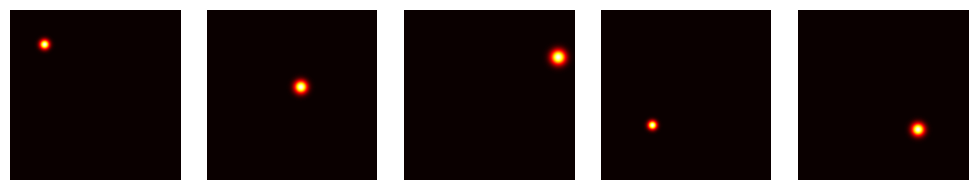

In [34]:
plt.figure(figsize=(10,2))

for ind, component_image in enumerate(component_images):
    plt.subplot(1,5,ind+1)
    plt.imshow(component_image, cmap='hot')
    plt.axis('off');

plt.tight_layout()

Simulate their time course as instant onset, exponential decay:

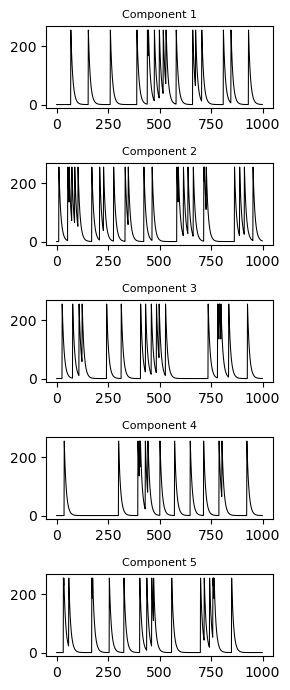

In [35]:
tau = 10 # 4
max_amp = 255  # just to make saving as uint8 in opencv simple
amps_all = []

for component_num in np.arange(num_components):
    amps = []
    amp = 0
    for time_step in np.arange(num_frames):
        if np.random.uniform(0,1) > 0.98:  #0.98
            amp = max_amp
        else:
            amp = np.max(np.array([amp - amp/tau, 0]));
        amps.append(amp)
    amps = np.array(amps)
    amps_all.append(amps)
amps_all = np.array(amps_all)

plt.figure(figsize=(3, 7))
for ind, signal in enumerate(amps_all):
    plt.subplot(5,1,ind+1)
    plt.plot(amps_all[ind], color='k', linewidth=0.75)
    plt.title(f"Component {ind+1}", fontsize=8)
plt.tight_layout()

Simulate calcium movie that combines signals from all components.

In [36]:
movie = np.zeros((num_frames, image_size, image_size))
for frame_num in np.arange(num_frames):
    component0 = amps_all[0][frame_num]*component_images[0]
    component1 = amps_all[1][frame_num]*component_images[1]
    component2 = amps_all[2][frame_num]*component_images[2]
    component3 = amps_all[3][frame_num]*component_images[3]
    component4 = amps_all[4][frame_num]*component_images[4]
    movie[frame_num] = component0 + component1 + component2 + component3 + component4

movie_noised = movie + np.random.exponential(0.25, size=movie.shape)

Let's view the movie (this will work in colab, but not on all local machines):

In [ ]:
min_, max_ = np.percentile(movie_noised, 0.01), np.percentile(movie_noised, 99.99)
movie_noised = np.array((movie_noised-min_)/(max_-min_)*255,dtype='uint8')

imageio.mimwrite('/root/ca_synthetic.mp4', movie_noised, fps = 30,  quality=7)
mp4 = open('/root/ca_synthetic.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url))

If you are working locally, not on colab, the following will save as mp4 so you can open on your machine:

    import cv2
    fps = 25
    out = cv2.VideoWriter('ca_synthetic.mp4',
                          cv2.VideoWriter_fourcc(*'DIVX'),  #mp4v (encoding)
                          fps,
                          (image_size, image_size),
                          False) # is_color
    for frame in movie_noised:
        frame = frame.astype(np.uint8)
        out.write(frame)
    out.release()

## Convert movie to dims for NMF
Just like you converted each face to a 1d array, here we have each frame as a single vector so will end up with a num_frames by num_pixels array. Then run NMF.

In [37]:
num_pixels = image_size*image_size
reshaped_movie = np.reshape(movie, (num_frames, num_pixels));
reshaped_movie.shape

(1000, 40000)

Run NMF on this 2d-array-ified movie:

In [38]:
k = 5
alph_W = 0.9
L1_ratio = 0.9

In [39]:
%%time
estimator = NMF(k,
                init='nndsvdar',
                solver='mu',
                max_iter=100,
                alpha_W=alph_W,
                alpha_H=0,
                l1_ratio=L1_ratio,
                shuffle=True)

H = estimator.fit_transform(reshaped_movie)
W = estimator.components_

CPU times: total: 40.3 s
Wall time: 5.11 s


C:\Users\Eric\miniconda3\envs\ds\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


Plot components and estimated components in one figure (note NMF is not ordered, so they likely won't match up):

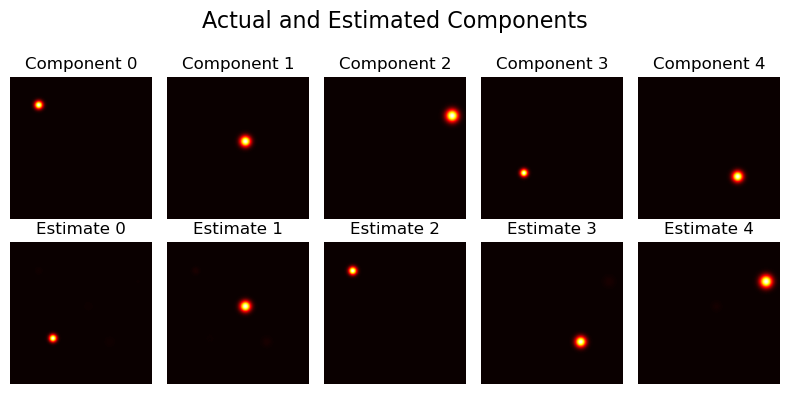

In [40]:
plt.figure(figsize=(8, 4))

w_sum = np.zeros(frame_shape)
# Actual components
for component_id, component_image in enumerate(component_images):
    plt.subplot(2,5,component_id+1)
    plt.imshow(component_image, cmap='hot')
    plt.title(f"Component {component_id}")
    plt.axis('off')

# Estimated components
for component_id, component in enumerate(W[:5]):
    plt.subplot(2, 5, component_id+6)
    w_frame = component.reshape(frame_shape)
    plt.imshow(w_frame, cmap='hot')
    w_sum += w_frame
    plt.title(f"Estimate {component_id}")
    plt.axis('off')

plt.suptitle('Actual and Estimated Components', fontsize=16, y=1)
plt.tight_layout()

Plot time course of the matching components (you need to select indices of estimate and actual):

In [41]:
actual_ind = 0
estimate_ind = 2
print('loaded')

loaded


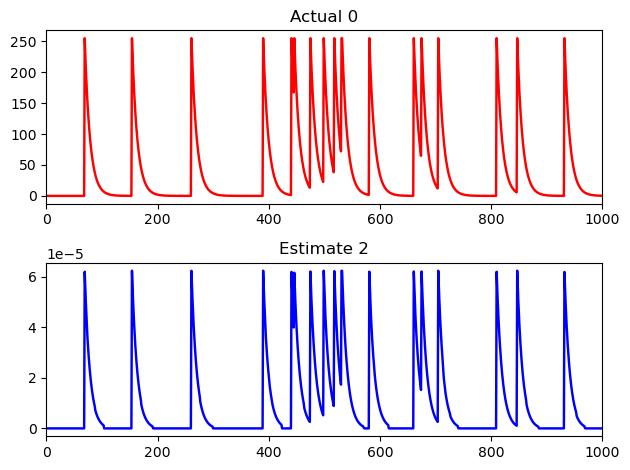

In [42]:
plt.figure()

plt.subplot(2, 1, 1)
plt.title(f"Actual {actual_ind}")
plt.plot(amps_all[actual_ind, :], color='r', linewidth=1.75);
plt.xlim(0, 1000)

plt.subplot(2,1,2)
plt.plot(H[:, estimate_ind], color='b', linewidth=1.75)
plt.title(f"Estimate {estimate_ind}")
plt.xlim(0, 1000)

plt.tight_layout()

It works really well!

## Exercises for the reader:
- Add contour plots for the actual/estimates, and inspect overlap.
- Automate the mapping from estimate to actual.
- Make a more realistic model of the components (how? how was our model of individual components simplified and unrealistic?).
- Automate k selection.

Add what point does the off-the-shelf NMF break down, latch onto noise, does the selection of the components become tougher, or the components become harder to interpret?

It's because of such realism that we see in actual neural recordings that *constrained* NMF comes in. As we saw, even NMF from scikit-learn is quite a bit more complex than simply minimizing the distance between X and WH.

PCA (svd) used to be popular before NMF. How well does it work with our simple neural example? When does it break down?